#  Podstawy Aproksymacji (część II): Deep Learning


##  Projekt: Rozpoznawanie ras psów z wykorzystaniem biblioteki Keras.

### Temat został opracowany przez:
### Michał Foryt - nr indeksu: 84172, adres e-mail: mf84172@student.sgh.waw.pl
### Szczepan Gabiec - nr indeksu: 101697, adres e-mail: sg101697@student.sgh.waw.pl
### Paweł Wróblewski - nr indeksu: 78793, adres e-mail: pw78793@student.sgh.waw.pl

<img src="meme2.jpg" style="width: 400px;">

## Wprowadzenie

Celem projektu jest stworzenie algorytmu służącego do rozpoznawaniu ras psów porzy wykorzystaniu biblioteki Keras, w oparciu o TensorFlow. Zbiór z którego korzystaliśmy pochodzi z jednego z konkursów zorganizowanych przez portal Kaggle i znajduje się pod tym linkiem: https://www.kaggle.com/c/dog-breed-identification. Z uwagi na jego rozmiar (~750MB) nie bedzie on dołączony bezpośrednio do kodu.  

W skład zbioru wchodzi około 10 tysięcy zdjęć, a wśród nich można wyróźnić 120 klas (ras psów). Pracując na tych danych, będziemy mogli stworzyć algorytm bazujący na głębokim uczeniu sieci neuronowych. W dużym uproszczeniu, zadaniem tego typu algorytmu jest rozpoznawanie obrazów podobnie, jak robi to umysł ludzki - "oglądając" ogromną pulę zdjęć z czasem rozpoznaje charakterystyczne cechy dla danego obiektu, przykładowo że rottweilera można poznać po tym, że jest duży i ma krótką, ciemną sierść, a york ma krótkie łapy i jest mocno owłosiony. Innymi słowy, algorytm najpierw zbiera dużą ilość danych, a następnie pozwala komputerowi zapoznać się z każdym z nich. Opierając się na dużych bazach danych i zauważając pojawiające się wzorce, komputery mogą rozpoznać obrazy i sformułować odpowiednie tagi i kategorie.



## 1. Konwolucyjne Sieci Neuronowe 
Konwolucyjne Sieci Neuronowe (ang. <i>CNN, Convolutional neural networks</i>, tłumaczone także jako <i>Splotowe Sieci Neuronowe</i>) w sprytny sposób redukują liczbę przyjmowanych parametrów. Zamiast działać na sieci, w której neurony są połączone każdy z każdym, podejście jakie prezentują CNN wykorzystują wielokrotnie te same parametry. Kluczem do sukcesu konwolucyjnych sieci jest fakt, że wychodza one z założenia, że wystarczy lokalne zrozumienie obrazu. Innymi słowy, algorytm skupia się na tym, by  stopniowo filtrować różne części danych uczących i wyostrzać ważne cechy w procesie dyskryminacji wykorzystanym do rozpoznawania lub klasyfikacji wzorców. W praktyce zaletą takiego podejścia jest posiadanie mniejszej liczby parametrów, co przekłada się na znaczne zmniejszenie czasu potrzebnego do wytrenowania modelu.

Rozważmy obraz o wymiarze 256 × 256 pikseli. Zamiast przetwarzać cały obraz naraz, CNN może skutecznie skanować go po kawałku - powiedzmy, patrząc na fragment o wymiarach 5 × 5. Taka ramka o wymiarach 5 × 5px przesuwa się wzdłuż obrazu (zwykle od lewej do prawej i od góry do dołu), jak pokazano na poniższym rysunku. 

<img src="cnn_concept.jpeg" style="width: 350px;">

Tempo przesuwania się takiej ramki nazywamy "długością kroku". Na przykład długość kroku 2 oznacza, że okno 5 × 5 przesuwa się o 2 piksele na raz, aż obejmie cały obraz. Taka ramka 5 x 5 pikseli przekłada się na macierz wag o wymiarze 5 x 5. 

Tego typu operacja ma miejsce w warstwie konwolucyjnej sieci neuronowej. Typowa CNN posiada wiele tego typu warste. Każda z nich zazwyczaj generuje wiele różnych splotów (ang. <i>convolutions</i>). Co za tym idzie, macierz wagowa takiego tensora (czyli obiektu matematycznego będącego uogólnieniem pojęcia wektora) ma wymiary 5 × 5 x n, gdzie n liczbą konwolucji (splotów).

Przykładowo, załóżmy że przepuszczamy rozważany obraz przez pojedynczą warstwę splotu jako macierz wagowa 5 x 5 x 64 z ramką 5 x 5. Co za ty idzie, taki model posiada 5 x 5 x64 = 1600 parametrów, podczas gdy pełna sieć dla obrazu 256 x 256px wymagałaby zastosowania 65 536 parametrów.

## 2. Przetworzenie zbioru danych
Jak już wspomnielismy na początku, wykorzystamy zbiór danych dotyczący rozpoznawania ras psów, który wstępnie został już podzielony na zbiór treningowy i testowy. Nazwa każdego z obrazów jest też jednocześnie jego unikalnym id. Cały zestaw danych zawiera zdjęcia 120 ras, jednak dla urposzczenia modelu przyjmiemy założenie, że ograniczamy się jedynie do rozpoznawania 8 najpopularniejszych.

Dla porządku, wszystkie niezbędne importy zastosujemy poniżej. Dzięki temu uzyskamy większa czytelność oraz podcas tworzenia naszej funkcjonalności będziemy mieli pewność, że wszystkie niezbędne paczki zostały już ściągnięte.  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import matplotlib.pyplot as plt
from shutil import copyfile
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import cv2
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

Czytamy dane z pliku labels, które mapują id zdjęcia z jego opisem. na zbiorze treningowym. 

In [3]:
labels = pd.read_csv('labels.csv')
labels_dict = {i:j for i,j in zip(labels['id'],labels['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir('train')]

Tworzymy nowe katalogi, które zawierają zbiory zdjęć - treningowy i testowy. 

In [4]:
if not os.path.exists('training_images'):
        os.makedirs('training_images')

if not os.path.exists('validation_images'):
    os.makedirs('validation_images')

Otwieramy folder z danymi treningowymi. Dla każdego z nich przygotowujemy katalogi, do których następnie będziemy zapisywać zdjęcia ras w osobne podkatalogi.

In [5]:
os.chdir('training_images')
for curClass in classes:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

 To samo robimy dla zbioru testowego. 

In [6]:
os.chdir('../validation_images')
for curClass in classes:    
    if not os.path.exists(curClass):
        os.makedirs(curClass)

Wracamy do głównego folderu. Po przygotowaniu odpowiednich katalogów możemy je wypełnić. Mamy około 20.5 tysięcy zdjęć, dzielimy je w proporcjach około 40:60 między zbiór treningowy i testowy - pierwsze 8 tysięcy zdjęć kopiujemy do odpowiednich katalogów w części uczącej, a pozostałe zdjęcia do przypisanych folderów w walidującej. 

In [7]:
os.chdir('..')
count = 0 
destination_directory = 'training_images/'
for item in images:
    if count >7999:
        destination_directory = 'validation_images/'
    filekey = os.path.splitext(item)[0]
    target_file = destination_directory+labels_dict[filekey]+'/'+item
    if not os.path.exists(target_file):
        copyfile('train/'+item, target_file)
    count +=1

## 3. Image Augmentation - Przekształcenie obrazów
Image augmentation to technika polegająca na przekształcaniu oryginalnego obrazu tak, by uzyskać nowe dane testowe. Przykładowo dzieje się to poprzez dodanie szumu albo lustrzane odbicie. Dzięki temu możemy uzyskć więcej zdjęć testowych. W Pythonie, służy do tego klasa ImageDataGenerator, która ustawia parametry takie jak rotacja obrazu przybliżenie czy znieształcenie. Wykorzystamy ją do wygenerowania setek wariacji jednego ze zdjęć.   

In [8]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.3,
        height_shift_range=0.2,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('training_images/afghan_hound/0d5a88f0ab2db8d34b533c69768135e8.jpg') 
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

if not os.path.exists('preview'):
        os.makedirs('preview')

for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # W przeciwnym pzypadku generator będzie działać w nieskonczoność

## 4. Implementacja sieci neuronowej
Na początku dokonujemy przekształcenia zbioru testowego. Przeskalowanie to wartość, o którą pomnożymy dane przed jakimkolwiek innym przetwarzaniem. Nasze oryginalne obrazy składają się ze współczynników RGB w zakresie 0–255, ale takie wartości byłyby zbyt wysokie, aby nasz model mógł je przetworzyć (biorąc pod uwagę typowy learning rate), więc zamiast tego celujemy wartości z zakresu od 0 do 1, skalując je z dokładnością 1/255. Z kolei parametr shear_range pozwala przekształcić obraz pod pewnym kątem (bardziej obrazowo - zamiast obrazu w postaci kwadratu otrzymujemy równoległobok), natomiast zoom_range odpowiada za stopień przybliżenia bądź oddalenia obrazka, a horizontal_flip tworzy jego odbicie. Wszystkie te zabiegi mają sprawić, że zbiór treningowy bedzie nieco różnić się od zbioru testowego, by uniknąć nadmiernego dopasowania do danych.


In [9]:
#Train datagen tworzy generator danych testowych
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

#Test_datagen tworzy generator danych walidacyjnych. W tym przypadku jedynie normalizujemy rozmiar zdjęć. 
test_datagen = ImageDataGenerator(rescale=1./255)

Mając stworzone odpowiednie generatory można przystąpić do właśniwego wygenerowania odpowiednich zdjęć. Przekazując parametr class_mode='categorical' unikamy manualanej konwersji etykiet na odpowiednie wektory - generator zrobi to za nas. 

In [10]:
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.


Majac już przygotowane dane treningowe i testowe możemy przystąpić do tworzenia modelu sieci konwolucyjnej. Wykorzystamy model sekwencyjny (Sequential), który jest odpowiedni dla zwykłego stosu warstw, gdzie każda warstwa ma dokładnie jeden tensor wejściowy i jeden tensor wyjściowy. Tego typu model nie sprawdziłby się w przypadku, gdy przykładwo model lub którakolwiek z warstw ma wiele wejść lub wyjść.

Tworzymy pierwszą warstwę, którą dodamy do sieci. Ponieważ dotyczy ona obiektów dwuwymiarowych, wykorzystamy klasę *Conv2D*. Jako parametry w konstruktorze przekazujemy następujace argumenty:   
- **filters** - liczba całkowita, określająca wymiar otrzymany na wyjściu (tj. liczba filtrów wyjściowych w konwolucji).
- **kernel_size** - lista / krotka składająca się z 2 liczb całkowiych, okreslająca rozmiar okna 2D. 
- **input_shape** - ponieważ jest to pierwsza warstwa należy podać wektor wejsćiowy. W tym przpyadku będzie to okno 128x128 px, a przez 3 oznaczamy listę 3 elementów - nasycenie odpowiednich barw w notacji RGB. 
- **activation** - oznacza funckję aktywacji w danej warstwie. W tym przypadku jest to rectified linear unit (ReLU), choć możliwe jest też ustawienie np. funkcji sigmoidalnej lub wykładniczej.  

Warstwa łącząca (pooling layer) służy do progresywnej redukcji rozmiaru przestrzennego do zredukowania ilości cech i złożoności obliczeniowej sieci. Najczęściej w sieciach konwolucyjnych stosujemy warstwę MaxPool która przesuwa filtry (tu - 2x2) przez całą macierz wyciągając największą wartość z okna filtra i zapisuje ją do następnej mapy.

Najważniejszy powód stosowania warstw łączących jest uchronienie modelu przed przeuczeniem. Czasami stosujemy też warstwę opuszczającą, która zastępuje warstwę łączącą. Należy być ostrożnym przy stosowaniu warstwy łączącej, szczególnie w zadaniach wizyjnych, gdyż może to spowodować utratę lokalnej wrażliwości modelu mimo zmniejszenia rozmiaru modelu.

Metoda porzucania (dropout) to także popularny sposób do walki z przetrenowaniem w przypadku sieci neuronowych. Dropout polega na losowym ustawieniu wychodzących krawędzi ukrytych jednostek (neuronów tworzących ukryte warstwy) na 0 przy każdej aktualizacji fazy treningu.

Metoda ta jest bardzo efektywna, ponieważ co każde przejście losowo wyłączane są połączenia. Dzięki temu sieć neuronowa nie nauczy się „na pamięć” zbyt szybko, ponieważ architektura co przeliczenie odrobinę się zmienia poprzez zerowanie losowych połączeń neuronów.

W Tensorflow dodajemy kolejne warstwy wykorzystując „Dropout” oraz definiując jaka część neuronów ma zostać zapomniana. Np. dla wartości 0.2 zostanie wylosowanych 20% połączeń do wyzerowania.

In [11]:
clf = Sequential()
clf.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))   
clf.add(MaxPooling2D(pool_size=(2,2)))  
clf.add(Dropout(0.25))

clf.add(Conv2D(64,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.3))

clf.add(Conv2D(128,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.5))


clf.add(Conv2D(128,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.5))

clf.add(Conv2D(64,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
clf.add(Dropout(0.3))

clf.add(Flatten())
        
#Adding An ANN
clf.add(Dense(units=256,activation='relu'))

#clf.add(Dropout(0.5))
clf.add(Dense(units=120,activation='softmax'))
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy

clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

W tym modelu zastosowaliśmy metodę wczesnego zakończenia (early stopping). Polega na tym, by zakończyć uczenie, gdy strata na zbiorze testowym nie rośnie. Czyli trenując dalej sieć nie poprawiamy mocy modelu na zbiorze testowym. 
W Tensorflow mamy do dyspozycji funkcję EarlyStopping, która monitoruje stratę na zbiorze testowym po zakończeniu każdej epoki. Jeśli strata nie maleje, wówczas trening sieci zostaje zatrzymany. Należy zdefiniować 3 podstawowe parametry ustawiając early stopping:

- **monitor** – definiujemy, co chcemy monitorować na podstawie czego zatrzymamy proces uczenia,
- **patience** – tym parametrem definiujemy liczbę epok po ilu zatrzyma się nasz model jeśli nie zaobserwujemy zmniejszania się funkcji straty,
- **verbose** – w jaki sposób będzie wyświetlana informacja o early stoping.

W naszym modelu skonfigurujemy tylko parametr patience, resztę pozostawiamy domyślnie. 

In [12]:
early_stopping_monitor=EarlyStopping(patience=10)

Uruchamiamy metodę *fit*. *keras.fit()* oraz *keras.fit_generator()* stanowią dwie odrębne biblioteki do głębokiego uczenia maszynowego, które mogą być wykorzystane do trenowania zarówno modeli machine learningowych jak i deep learningowych. Obie funkcje wykonują to samo, natomiast z uwagi na to, że *fit_generator* jest już przestarzała, wykorzystamy tę pierwszą metodę.

Wykorzystana przez nas metoda przyjmuje następujące parametry:
- training_set - zbiór treningowy
- steps_per_epoch - to liczba iteracji wsadowych (*batch iterations*), zanim epoka zostanie uznana za zakończoną. Jeśli mamy zestaw treningowy o ustalonym rozmiarze, można go zignorować, ale może być przydatny, jeśli mamy duży zestaw danych lub generujemy losowe rozszerzenia danych.
- batch_size - wielkość próbki danych (batch). Określa liczbę próbek w każdej mini partii.
- validation_steps - parametr podobny do steps_per_epoch, ale ma zastosowanie w zestawie danych walidacyjnych zamiast w danych szkoleniowych.

Aby odnaleźć odpowiednią kombinację zastosowaliśmy różne warianty modelu.
- modyfikacja wartości parametru patience (podniesienie wartości z 6 na 10, aby proces nauki nie zakończył się zbyt szybko). 
- steps_per_epoch - początkowo parametr ten ustawiliśmy na 400, po czym zmienilismy jego wartość na proporcje względem rozmiaru zbioru treningowego (próbowaliśmy podziału przez 16, 8, 4), jednak finalnie uzyskane wartości okazywały się być zbyt niskie. Analogicznie w przypadku validation_steps z tą różnicą, że tutaj braliśmy zbiór testowy. Również czas obiczeń stawał się bardzo długi. 
- Na poczatku zastosowaliśmy tylko 3 warstwy sieci, po czym zwiększyliśmy jej rozmiar do 5 warstw. Dodatkowo dodaliśmy parametr Dropout, by kontrolować przeuczenie.
- Zwiększyliśmy liczbę epok, z 50, przez 75, 100, 120, dochodząc do 180.

Zastosowane poprawki pomogły nam poprawić jakość modelu z accuracy równgo 7% do poziomu 

In [13]:
hist=clf.fit(
        training_set,
        steps_per_epoch=len(training_set)/2, 
        validation_steps=len(test_set)/2,
        epochs=180,
        validation_data=test_set,
        callbacks=[early_stopping_monitor])

Epoch 1/180
200/200 [==============================] - 178s 888ms/step - loss: 4.7964 - accuracy: 0.0100 - val_loss: 4.7838 - val_accuracy: 0.0116
Epoch 2/180
200/200 [==============================] - 185s 926ms/step - loss: 4.7846 - accuracy: 0.0103 - val_loss: 4.7860 - val_accuracy: 0.0091
Epoch 3/180
200/200 [==============================] - 185s 925ms/step - loss: 4.7781 - accuracy: 0.0122 - val_loss: 4.7838 - val_accuracy: 0.0107
Epoch 4/180
200/200 [==============================] - 181s 903ms/step - loss: 4.7844 - accuracy: 0.0077 - val_loss: 4.7785 - val_accuracy: 0.0118
Epoch 5/180
200/200 [==============================] - 158s 789ms/step - loss: 4.7806 - accuracy: 0.0088 - val_loss: 4.7834 - val_accuracy: 0.0125
Epoch 6/180
200/200 [==============================] - 148s 740ms/step - loss: 4.7808 - accuracy: 0.0125 - val_loss: 4.7836 - val_accuracy: 0.0109
Epoch 7/180
200/200 [==============================] - 150s 750ms/step - loss: 4.7787 - accuracy: 0.0113 - val_loss: 4

200/200 [==============================] - 118s 589ms/step - loss: 4.2751 - accuracy: 0.0535 - val_loss: 4.4086 - val_accuracy: 0.0417
Epoch 57/180
200/200 [==============================] - 118s 589ms/step - loss: 4.2716 - accuracy: 0.0555 - val_loss: 4.4601 - val_accuracy: 0.0408
Epoch 58/180
200/200 [==============================] - 119s 594ms/step - loss: 4.2570 - accuracy: 0.0560 - val_loss: 4.4484 - val_accuracy: 0.0429
Epoch 59/180
200/200 [==============================] - 119s 595ms/step - loss: 4.2441 - accuracy: 0.0540 - val_loss: 4.4185 - val_accuracy: 0.0436


Mając wytrenowany model możemy go przetestować. W tym celu najpierw normalizujemy rozmiar zdjęć, a następnie wykorzystując metodę *predict* stosujemy nasz model do klasyfikacji danych testowych.   

In [14]:
test_set = []
test_set_ids = []
for curImage in os.listdir('test'):
    test_set_ids.append(os.path.splitext(curImage)[0])
    curImage = cv2.imread('test/'+curImage)
    test_set.append(cv2.resize(curImage,(128, 128)))

In [15]:
test_set = np.array(test_set, np.float32)/255.0

In [16]:
predictions = clf.predict(test_set)

In [17]:
predictions[0].shape

(120,)

Poniżej lista poszczególnych ras wraz z przypisanymi id.

In [18]:
training_set.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [19]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(120)]

Dla każdego ze zdjęć otrzymaliśmy prawdopodobienstwo przynależności do każdej z ras. "Wygrywa" ta, dla której wartość jest największa.

In [20]:
predictions_df = pd.DataFrame(predictions)
predictions_df.columns = column_names
predictions_df.insert(0,'id', test_set_ids)
#predictions_df.index = test_set_ids
predictions_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,264833ebf9f2bf8b07651f72916f8c75,0.004973,0.008849,0.009799,0.006377,0.012081,0.016524,0.004380,0.013987,0.014616,...,0.003485,0.011724,0.001662,0.012672,0.006028,0.015467,0.007532,0.011599,0.009254,0.006394
1,ae2b2271318cc84364931ada1c75b295,0.000013,0.010415,0.000399,0.007956,0.006298,0.000013,0.002086,0.001356,0.000249,...,0.034851,0.000418,0.000662,0.001188,0.009345,0.001190,0.026695,0.005328,0.007585,0.014946
2,35d9bcc10f2762ed900f7a2c48d37c15,0.011253,0.012878,0.008130,0.014887,0.007970,0.004598,0.015277,0.006521,0.003825,...,0.007588,0.006232,0.005367,0.003928,0.008974,0.004629,0.002303,0.006317,0.004619,0.009194
3,66fabb7f526d842a06829a770b959b9d,0.002752,0.017753,0.028376,0.018867,0.008121,0.002358,0.014366,0.005857,0.002111,...,0.006824,0.003504,0.008466,0.002689,0.017079,0.004156,0.001761,0.009937,0.003191,0.007780
4,cf5b51fe08e3337217fca120a03ac993,0.008872,0.014479,0.011384,0.010697,0.009027,0.007067,0.011909,0.007909,0.004364,...,0.007758,0.005329,0.006180,0.004746,0.009110,0.005859,0.002836,0.006183,0.004767,0.006992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,5dac8f13467994de6ba778df1cdba3fd,0.021089,0.009513,0.006204,0.019570,0.004662,0.015485,0.017958,0.004477,0.004410,...,0.004604,0.008117,0.004837,0.001177,0.003099,0.003038,0.000776,0.011701,0.001460,0.006164
10353,4064e9fe3249051177c27d4d505c1d83,0.000323,0.016861,0.005937,0.006728,0.008519,0.000444,0.003315,0.010771,0.002084,...,0.017594,0.002045,0.003176,0.003863,0.013445,0.004858,0.016281,0.021490,0.006694,0.011760
10354,a9fa08dfaec85e98387911dd4364ce79,0.002919,0.009047,0.019081,0.020490,0.005408,0.001090,0.018247,0.013728,0.002240,...,0.006309,0.006974,0.015015,0.003541,0.008495,0.004511,0.000740,0.011386,0.006220,0.008212
10355,3be602e5b58c0274b72ad5322d3c8601,0.004407,0.013429,0.011236,0.007467,0.009799,0.003413,0.009195,0.013759,0.006266,...,0.008467,0.005802,0.005664,0.004282,0.010893,0.009495,0.007772,0.011357,0.007277,0.013747


Wyniki zapisujemy do pliku CSV. 

In [21]:
predictions_df.to_csv('interim_submission.csv',sep=",")

## 5. Graficzna reprezentacja

Poniższy wykres przedstawia stratę (*loss*) na zbiorze walidacyjnym. Im niższa strata, tym lepszy model (chyba że model zbytnio dopasował się do danych treningowych). Stratę oblicza się na podstawie zbioru treningowego i walidacyjnego, a jego interperacja określa, jak dobrze model radzi sobie na tych dwóch zestawach. W przeciwieństwie do dokładności (*accuracy*), strata nie jest wyrażana jako procent. Jest to suma błędów popełnianych dla każdego przykładu w zestawach szkoleniowych lub walidacyjnych.

W przypadku sieci neuronowych strata jest zwykle ujemnym logarytmem wiarygodności i suma kwadratów reszt odpowiednio dla klasyfikacji i regresji. Następnie oczywiście głównym celem w modelu uczenia się jest zmniejszenie (minimalizacja) wartości funkcji straty w odniesieniu do parametrów modelu przez zmianę wartości wag wektora za pomocą różnych metod optymalizacji, takich jak propagacja wsteczna w sieciach neuronowych.

Wartość straty informuje, jak dobrze lub źle zachowuje się określony model po każdej iteracji optymalizacji. Idealnie byłoby oczekiwać zmniejszenia straty po każdej lub kilku iteracjach.

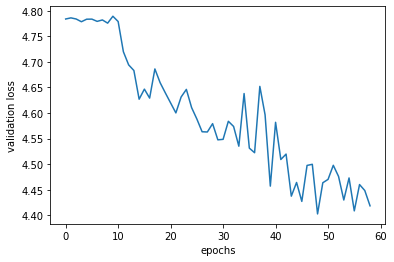

In [22]:
plt.plot(hist.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

Dokładność modelu jest zwykle określana po poznaniu i ustaleniu parametrów modelu i braku daleszej poprawy w uczenia się. Następnie dane testowe są podawane do modelu i rejestrowana jest liczba błędów (klasyfikacja zero-jedynkowa), które popełnił model, po porównaniu z oznaczeniami. Następnie obliczany jest odsetek błędnej klasyfikacji.

Na przykład, jeśli liczba próbek testowych wynosi 1000, a model poprawnie klasyfikuje 952 próbki, to dokładność modelu wynosi 95,2%.

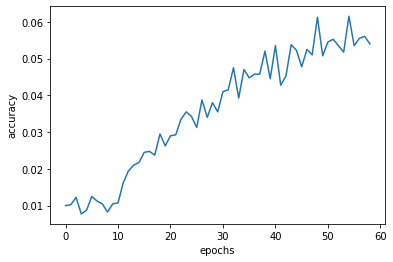

In [23]:
plt.plot(hist.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Poniżej znajduje się porównanie dokładności modelu na zbiorze testowym i treningowym. Jak widać, dokładność na zbiorze walidacyjnym nie odbiega zbytnio od dokładności na zbiorze treningowym, a więc oba zbiory są dobrze przygotowane, a dodatkowo model nie jest przeuczony. Martwić może natomiast fakt, że sieć osiągnęła małą precyzję. 

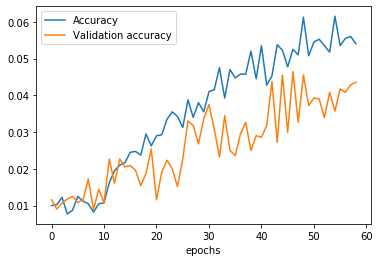

In [24]:
plt.plot(hist.history['accuracy'],label="Accuracy")
plt.plot(hist.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.xlabel('epochs')
plt.show()

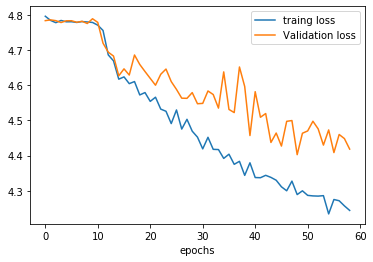

In [25]:
plt.plot(hist.history['loss'],label="traing loss")
plt.plot(hist.history['val_loss'], label="Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.show()

## Podsumowanie

Tak jak zostało to opisane we wprowadzeniu na podstawie zdjęć psów, z wykorzystaiem uczenia sieci neuronowej przypisaliśmy ich rasy. Proces uczenia sieci wykonaliśmy poprzez Konwulacyjną (Splotową) sieć neuronową ze względu na jej efektywniejsze działanie nie wykorzystujące dużej ilości parametrów.
Podzieliliśmy zbiory na testowy ( w tym treningowy)  i walidacyjny, następnie załadowaliśmy odpowiednią proporcjonalną ilość zdjęć. Następnie dokonaliśmy prob uczących przez sieć z wykorzystaniem biblioteki KERAS.
Proces wyglądał następująco:

- Na wejściu algorytm otrzymuje zbiór zawierający N obrazów, każdy z nich przypisany jest do jednej z K klas. 
- Następnie wykorzystuje się zbiór treningowy do szkolenia klasyfikatora tak, aby był on w stanie jak najepiej przyporządkować etykietę do zdjęcia.
- Na koniec ocenia się jakość klasyfikatora, prosząc go o przewidywanie etykiet dla nowego zestawu obrazów, których nigdy wcześniej nie widział, po czym porównamy prawdziwe etykiety tych obrazów z przewidywanymi przez klasyfikator.

Po przetworzeniu procesów otrzymaliśmy wyniki:
Na zbiorze walidacyjnym wraz ze wzrostem liczby przetworzonych zdjęć rośnie precyzja przypisywania nazwy rasy do danego zdjęcia. Niestety dla tak wielkiego zbioru różnych klas nasz model okazuje się byc zbyt prosty, aby sprostać temu zadaniu. Accuracy jest realtywnie niskie, co można tłumaczyć m.in. małą liczbą warstw sieci.     

Z uwagi na ograniczenia związane z terminem oddania projektu a także z ograniczoną mocą obliczeniową, którą dysponujemy (po zastosowaniu poprawek musieliśmy czekać nawet do 24 godzin, aż model ponownie się przeliczy) oczywiste jest, że można dokonać jeszcze wielu różnych poprawek (np. zwiększenie liczby warstw sieci) oraz rozpatrzeć kilka alternatywnych modeli. 

## Bibliografia
- http://home.agh.edu.pl/~horzyk/lectures/ai/SztucznaInteligencja-UczenieG%C5%82%C4%99bokichSieciNeuronowych.pdf
- https://keras.io/api/
- https://miroslawmamczur.pl/przykladowa-siec-neuronowa-mlp-w-tensorflow/
- https://ksopyla.com/python/tensorflow/wielowarstwowa-siec-neuronowa-w-tensorflow-do-klasyfikacji-cyfr-z-mnist/
- https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33